# Inventory Monitoring at Distribution Centers



## Problem Statement

In Amazon's warehouse operations, robots are used to move items as part of their daily processes. These items are transported in bins, each containing multiple objects. To ensure that customer orders are fulfilled correctly, it’s crucial to verify that the right number of items are included in each delivery. Amazon's robotics, scanning equipment, and computer systems in fulfillment centers can track millions of items daily. However, an inventory system reliant solely on manual checks is highly labor-intensive.

This project aims to leverage the "Amazon Bin Image Dataset" to develop machine learning models that can accurately recognize and count the objects in each bin. The dataset includes a wide range of images captured in warehouse settings, showing various items within bins. By implementing advanced image recognition and classification algorithms, the objective is to build a robust system that can reliably identify products, monitor inventory levels, and streamline order picking processes. Additionally, the resulting model seeks to reduce manual labor, minimize errors, enhance efficiency, and, most importantly, simulate a complete machine learning pipeline for logistics data processing.

## Modules instalation and import

In [1]:
!pip install -U torch torchvision
!pip install -U smdebug
!pip install -U seaborn plotly opencv-python shap imageio bokeh
!pip install -U sagemaker
!pip install tqdm

  Using cached torch-2.5.1-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached torchvision-0.20.1-cp311-cp311-manylinux1_x86_64.whl.metadata (6.1 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-many

In [2]:
# Import any packages that you might need

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import host_subplot
import boto3
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import sagemaker
from sagemaker.predictor import Predictor
from sagemaker.pytorch import PyTorch
from sagemaker.pytorch import PyTorchModel
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.debugger import (
    Rule, ProfilerRule, rule_configs,
    DebuggerHookConfig, CollectionConfig,
    ProfilerConfig, FrameworkProfile, 
)


from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import random
import io
import os
import requests
import json

from PIL import Image
from IPython.display import display

/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Data Preparation

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [3]:
session = sagemaker.Session()

bucket = 'mle-project-bucket'
print("Default Bucket: {}".format(bucket))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: mle-project-bucket
AWS Region: us-east-1
RoleArn: arn:aws:iam::920813457542:role/service-role/AmazonSageMaker-ExecutionRole-20250114T135076


In [4]:
# Create channel for data input's location
train_loc = "s3://%s/dataset/bin-images/train" % bucket
validation_loc = "s3://%s/dataset/bin-images/valid" % bucket
test_loc = "s3://%s/dataset/bin-images/test" % bucket

channels = {
    "training": train_loc,
    "validation": validation_loc,
    "testing": test_loc
}

In [5]:
def download_and_arrange_data():
    with open('file_list.json', 'r') as f:
        d=json.load(f)
        # split data train =0.6, test=0.2, validation=0.2
        train = {}
        test = {}
        validation = {}
        for k, v in d.items():
            train[k], test[k] = train_test_split(d[k], test_size =0.4, random_state=0)
            test[k], validation[k] = train_test_split(test[k], test_size=0.5, random_state=0)
        download_images(train, 'train')
        download_images(test, 'test')
        download_images(validation, 'validation')

def download_images(files_list, data_path):
    s3_client = boto3.client('s3')
    data_path = os.path.join('dataset', 'bin-images', data_path)
    for k, v in files_list.items():
        print(f"Downloading Images with {k} objects to the path {data_path}")
        directory=os.path.join(data_path, k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

# download_and_arrange_data() # used to copy the data

In [7]:
# Used once to move the data to S3
# !aws s3 sync ./dataset/ s3://{bucket}/dataset

## Dataset
To carry out this project, I will utilize the [Amazon Bin Image Dataset](https://registry.opendata.aws/amazon-bin-imagery/)

This dataset consists of 500,000 images of bins, each containing one or more items. Along with each image, there is a metadata file that provides details such as the number of objects, their dimensions, and the type of items. 


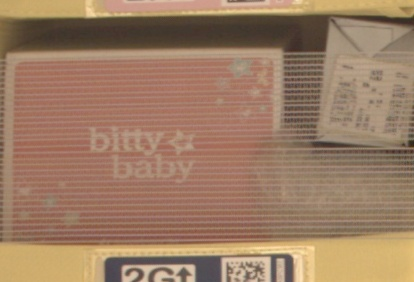

In [8]:
request_dict={ "url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/601.jpg" }
img_bytes = requests.get(request_dict['url']).content
Image.open(io.BytesIO(img_bytes))

Checking the number of imgaes under each lable

In [6]:
# Load the JSON data from the file
with open("file_list.json", "r") as file:
    data = json.load(file)

# Count the length of each list for each label
labels_length = {key: len(value) for key, value in data.items()}
labels_length

{'1': 1228, '2': 2299, '3': 2666, '4': 2373, '5': 1875}

[01/24/25 08:18:08] INFO     Using categorical units to plot a list of strings that are all         ]8;id=184409;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=616250;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py#223\223]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=260057;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=403983;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py#223\223]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

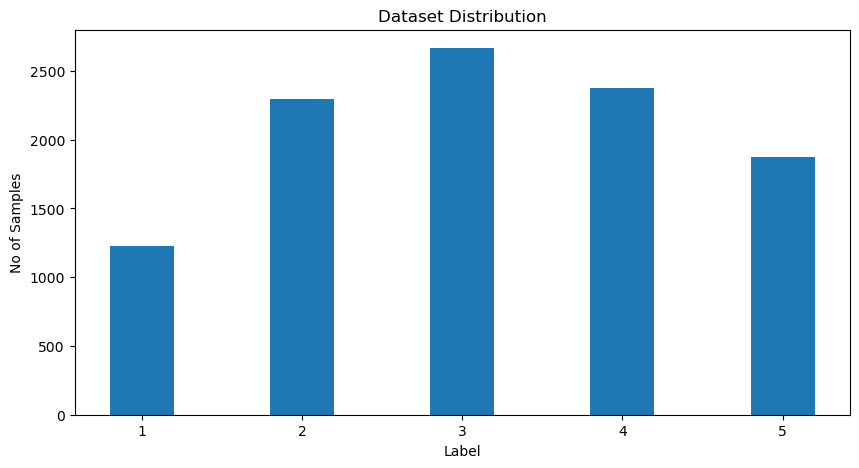

In [7]:
object_count = list(labels_length.keys())
no_of_samples = list(labels_length.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(object_count, no_of_samples ,width = 0.4)

plt.xlabel("Label")
plt.ylabel("No of Samples")
plt.title("Dataset Distribution")
plt.show()

In [8]:
data_path = './dataset'
# Collect image sizes
image_sizes_kb = []
for dirpath, dirs, files in os.walk(data_path ):
    for file in files:
        image_path = os.path.join(dirpath, file)
        image_size_kb = os.path.getsize(image_path) / 1024  # Convert bytes to KB
        image_sizes_kb.append(image_size_kb)

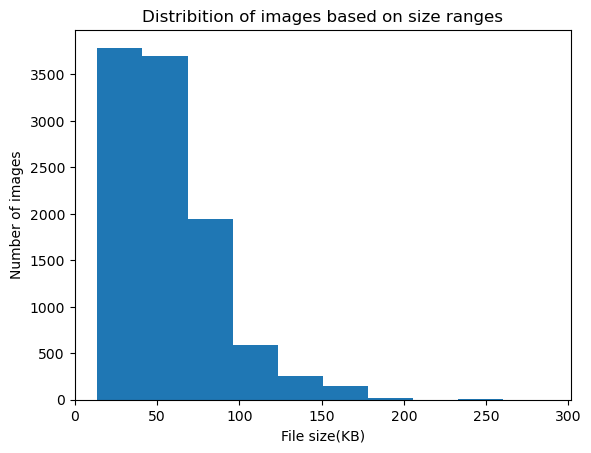

In [9]:
# Create histogram
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(image_sizes_kb)

plt.xlabel('File size(KB)')
plt.ylabel('Number of images')
plt.title('Distribition of images based on size ranges')
plt.show()

## Model Training


In [13]:
estimator = PyTorch(
    entry_point="train.py",
    role=role,
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    framework_version="1.8",
    py_version="py36",
)

In [14]:
inputs = "s3://mle-project-bucket/dataset/bin-images/" 
estimator.fit({"training": inputs}, wait=True)

[01/24/25 08:20:18] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=565818;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=503469;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=476694;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=278578;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

[01/24/25 08:20:19] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=220942;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=102969;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating training-job with name:                                       ]8;id=20806;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=490735;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\
                             pytorch-training-2025-01-24-08-20-18-828                                              

2025-01-24 08:20:22 Starting - Starting the training job...
2025-01-24 08:20:36 Starting - Preparing the instances for training...
2025-01-24 08:21:07 Downloading - Downloading input data...
2025-01-24 08:21:32 Downloading - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2025-01-24 08:22:07,838 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2025-01-24 08:22:07,841 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-01-24 08:22:07,848 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2025-01-24 08:22:07,850 sagemaker_pytorch_container.training INFO     Invoking user training script.
2025-01-24 08:22:08,023 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-01-24 08:22:08,034 sagemaker-training-toolkit INFO     No GPUs detected (normal if 

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning

I selected 3 hyperparameters to find the best configurations. These where:

- Learning Rate in range ContinuousParameter(0.001, 0.1) - it usually has small values based on a log scale. It affects the peed of training and if appropriate does not cause the learning process to diverge.
- Batch-size in range CategoricalParameter([32, 64, 128]) - it affects the speed of training and accuracy. With higher batch size we get more stable results but the speed of training deteriorates
- Number of Epochs in range IntegerParameter(1, 3) - it represents the number of trainings done with the selected model, high number can cause overfitting

In [15]:
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128]),
    "epochs": IntegerParameter(1, 3),
}

objective_metric_name = "Accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "Accuracy", "Regex": "Test set: Accuracy: ([0-9\\.]+)%"}]

In [16]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=1,
    max_parallel_jobs=1,
    objective_type=objective_type,
)

In [17]:
inputs = "s3://mle-project-bucket/dataset/bin-images/" 
tuner.fit({"training": inputs}, wait=True)

[01/24/25 08:38:44] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=44566;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=146343;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=386470;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=805209;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating hyperparameter tuning job with name:                          ]8;id=11078;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=707785;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#3383\3383]8;;\
                             pytorch-training-250124-0838                                                          

.............................................................................................................................................................................................................................................................................................................................................................!


In [18]:
# Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()


2025-01-24 09:07:33 Starting - Preparing the instances for training
2025-01-24 09:07:33 Downloading - Downloading the training image
2025-01-24 09:07:33 Training - Training image download completed. Training in progress.
2025-01-24 09:07:33 Uploading - Uploading generated training model
2025-01-24 09:07:33 Completed - Resource retained for reuse


In [19]:
tuner.best_training_job()

'pytorch-training-250124-0838-001-3467c1ad'

In [20]:
hyperparameters = {"batch-size": int(best_estimator.hyperparameters()['batch-size'].replace('"', '')),
                   "lr": best_estimator.hyperparameters()['lr'],
                   "epochs": int(best_estimator.hyperparameters()['epochs'].replace('"', ''))
                  }
hyperparameters

{'batch-size': 64, 'lr': '0.07727283462213592', 'epochs': 3}

In [21]:
hyperparameters = {'batch-size': 64, 'lr': '0.07727283462213592', 'epochs': 3}

### Model Profiling and Debugging

In [22]:
rules = [ 
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_configs=[
    CollectionConfig(
        name="weights",
        parameters={
            "train.save_interval": "5",
            "eval.save_interval": "1"
        }
    ),
    CollectionConfig(
        name="gradients",
        parameters={
            "train.save_interval": "5",
            "eval.save_interval": "1"
        }
    ),
    CollectionConfig(
        name="biases",
        parameters={
            "train.save_interval": "5",
            "eval.save_interval": "1"
        }
    ),
    CollectionConfig(
        name="CrossEntopyLoss_output_0", 
        parameters={
            "include_regex": "CrossEntropyLoss_output_0",
            "train.save_interval": "1",
            "eval.save_interval": "1"
        }
    )
]

debugger_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "5",
        "eval.save_interval": "1"
    },
    collection_configs=collection_configs
)

[01/24/25 09:15:25] WARNING  Framework profiling will be deprecated from tensorflow 2.12 and     ]8;id=101189;file:///opt/conda/lib/python3.11/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=719079;file:///opt/conda/lib/python3.11/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             pytorch 2.0 in sagemaker>=2.                                                          
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

In [23]:
estimator_deb = PyTorch(
    entry_point="train.py",
    role=role,
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)
inputs = "s3://mle-project-bucket/dataset/bin-images/"
estimator_deb.fit({"training": inputs}, wait=True)

[01/24/25 09:16:21] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=517776;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=284515;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=418357;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=215306;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=726127;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=647292;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#528\528]8;;\

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=863630;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=504512;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#528\528]8;;\

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=900380;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=665914;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating training-job with name:                                       ]8;id=323615;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=930830;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\
                             pytorch-training-2025-01-24-09-16-21-329                                              

2025-01-24 09:16:24 Starting - Starting the training job...
2025-01-24 09:16:46 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
ProfilerReport: InProgress
...
2025-01-24 09:17:26 Downloading - Downloading the training image......
2025-01-24 09:18:26 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2025-01-24 09:18:24,451 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2025-01-24 09:18:24,453 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-01-24 09:18:24,461 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2025-01-24 09:18:24,462 sagemaker_pytorch_container.training INFO     Invoking user training script.
2025-01-24 09:18:24,628 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed

In [24]:
import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator_deb.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: pytorch-training-2025-01-24-09-16-21-329
Region: us-east-1


In [25]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator_deb.latest_job_debugger_artifacts_path())
trial.tensor_names()

[2025-01-24 09:49:07.776 default:147 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-01-24 09:49:07.824 default:147 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-920813457542/pytorch-training-2025-01-24-09-16-21-329/debug-output


[01/24/25 09:49:07] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=347105;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=258110;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[2025-01-24 09:49:08.373 default:147 WARNING s3handler.py:184] Encountered the exception [SYS] unknown error (_ssl.c:2580) while reading s3://sagemaker-us-east-1-920813457542/pytorch-training-2025-01-24-09-16-21-329/debug-output/index/000000000/000000000104_worker_0.json . Will retry now


                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=867052;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=420627;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=884011;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=675174;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=512824;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=366485;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=327745;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=894291;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=375723;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=583494;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:09] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=823245;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=446371;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=861330;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=687723;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=642205;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=60684;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=790450;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=784077;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=501050;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=655228;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=505558;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=437366;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=251761;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=172409;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=590868;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=958394;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=120068;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=12745;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=604906;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=135031;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=837097;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=651091;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=900698;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=10028;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=833961;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=177179;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=339920;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=13986;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:10] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=109620;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=504876;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=505889;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=716066;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=833780;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=341658;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=48907;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=14366;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=928609;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=726946;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=905175;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=400533;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=707679;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=971872;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=983129;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=730644;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=212370;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=790224;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=883092;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=226159;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=395736;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=365594;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=292789;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=550145;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=400602;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=487931;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:11] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=831249;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=953919;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=393037;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=184959;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=489478;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=512565;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=757594;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=169407;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=523818;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=694934;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=537294;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=77057;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=813492;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=593865;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=495842;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=865742;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=974193;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=913746;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=685764;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=207262;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=46794;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=624132;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=433811;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=140259;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=222636;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=868416;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:12] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=821875;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=623832;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=416197;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=725960;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=711877;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=838943;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=113527;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=703940;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=589976;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=910272;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=15841;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=195052;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=639125;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=58605;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=604046;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=84737;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=614459;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=754676;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=583637;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=465171;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=189334;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=378421;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=206402;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=42909;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=213343;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=906484;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:13] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=895365;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=675284;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=182027;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=149895;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=557362;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=736087;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=494631;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=451011;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=935970;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=10216;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=76122;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=280004;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=665487;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=629260;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=35530;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=55241;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=414896;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=214562;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=83263;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=9134;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=109459;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=59778;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=227425;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=184195;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:14] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=555072;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=185824;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=356597;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=120329;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=275241;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=599686;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=948915;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=171985;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=993150;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=291513;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=343014;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=469978;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=563444;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=939798;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=20833;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=682634;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=88627;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=841759;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=839011;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=97020;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=753135;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=386404;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=64381;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=902037;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=619035;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=123921;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:15] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=784575;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=999408;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=479556;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=595702;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=75898;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=962479;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=210440;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=897958;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=56275;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=504268;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=266726;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=369055;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=969880;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=472985;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=995524;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=120292;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=595837;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=782346;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=957444;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=640504;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=53286;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=574143;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=433481;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=791375;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=182406;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=891702;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=352276;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=269644;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=155528;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=443939;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:16] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=1467;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=636713;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=854098;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=304271;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=190854;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=674467;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=618057;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=92531;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=265814;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=940794;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=365851;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=97500;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=267926;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=40174;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=702378;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=494324;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=111788;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=968807;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=882957;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=899003;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=921518;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=787055;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=776218;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=51686;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=314941;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=353613;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=330135;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=363216;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=407440;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=666763;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:17] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=22446;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=583040;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=35394;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=804697;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=426167;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=871524;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=787240;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=457976;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=503019;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=366283;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=142188;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=75750;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=645922;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=493995;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=11873;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=743805;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=791048;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=911716;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=887164;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=857938;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=91962;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=18562;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=898894;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=308294;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=73438;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=197416;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=499039;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=688130;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=115536;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=774849;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=884545;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=291758;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=456360;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=603521;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=688844;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=483607;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=581344;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=341765;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=28635;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=192612;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=606374;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=132751;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=939435;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=512960;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=956567;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=501638;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=836765;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=797697;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:18] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=840791;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=481864;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=800151;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=127613;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=744657;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=660712;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=95949;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=369806;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=414998;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=306570;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=604152;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=296956;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=448329;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=166074;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=452572;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=196143;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=656693;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=930351;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=256888;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=887187;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=270382;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=210906;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=541873;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=484227;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=903223;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=389854;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=3164;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=598734;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=691644;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=400714;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=760275;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=139475;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=969095;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=183868;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=890849;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=509407;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=772585;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=154576;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=519739;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=443967;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=876215;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=697063;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=953691;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=148853;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=106165;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=452437;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=993511;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=467015;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:19] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=47603;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=885198;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=917171;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=562508;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=727817;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=93729;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=187455;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=380974;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=945542;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=216589;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=341530;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=456013;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=325512;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=465875;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=159603;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=598459;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=671954;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=220894;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=119695;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=578921;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=269794;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=236568;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=221571;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=606959;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=448319;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=232504;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=879999;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=157124;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=941890;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=902646;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=694150;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=533788;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=683106;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=102140;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=417059;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=611461;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:20] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=573281;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=937949;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=362164;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=388562;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=777548;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=212516;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=524161;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=26797;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=621669;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=879937;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=897352;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=436323;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=715094;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=386496;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=920734;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=177937;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=24571;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=220337;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=283048;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=498885;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=560095;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=529177;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=749600;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=335694;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=654989;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=374080;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=36661;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=562969;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=407572;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=984584;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=80277;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=778432;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:21] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=253823;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=568404;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=437529;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=818016;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=769005;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=754309;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=387468;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=511149;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=391144;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=945446;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=84126;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=524797;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=423305;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=303329;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=365151;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=422962;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=657054;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=515744;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=650446;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=462387;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=50192;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=416840;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=38321;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=24763;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=843887;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=596685;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[2025-01-24 09:49:24.305 default:147 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2025-01-24 09:49:25.322 default:147 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'ResNet_bn1.bias',
 'ResNet_bn1.weight',
 'ResNet_conv1.weight',
 'ResNet_fc.bias',
 'ResNet_fc.weight',
 'ResNet_layer1.0.bn1.bias',
 'ResNet_layer1.0.bn1.weight',
 'ResNet_layer1.0.bn2.bias',
 'ResNet_layer1.0.bn2.weight',
 'ResNet_layer1.0.bn3.bias',
 'ResNet_layer1.0.bn3.weight',
 'ResNet_layer1.0.conv1.weight',
 'ResNet_layer1.0.conv2.weight',
 'ResNet_layer1.0.conv3.weight',
 'ResNet_layer1.0.downsample.0.weight',
 'ResNet_layer1.0.downsample.1.bias',
 'ResNet_layer1.0.downsample.1.weight',
 'ResNet_layer1.1.bn1.bias',
 'ResNet_layer1.1.bn1.weight',
 'ResNet_layer1.1.bn2.bias',
 'ResNet_layer1.1.bn2.weight',
 'ResNet_layer1.1.bn3.bias',
 'ResNet_layer1.1.bn3.weight',
 'ResNet_layer1.1.conv1.weight',
 'ResNet_layer1.1.conv2.weight',
 'ResNet_layer1.1.conv3.weight',
 'ResNet_layer1.2.bn1.bias',
 'ResNet_layer1.2.bn1.weight',
 'ResNet_layer1.2.bn2.bias',
 'ResNet_layer1.2.bn2.weight',
 'ResNet_layer1.2.bn3.bias',
 'ResNet_layer1.2.bn3.weight',
 'ResNet

In [26]:
# copied from exercises
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [27]:
# copied from exercises
from mpl_toolkits.axes_grid1 import host_subplot

tensor_name = 'CrossEntropyLoss_output_0'

steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
print("loaded TRAIN data")
steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
print("loaded EVAL data")

[01/24/25 09:49:25] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=345644;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=93895;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=629402;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=733206;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:26] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=561286;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=60595;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=953073;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=456882;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=755789;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=180544;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:27] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=93776;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=333566;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:28] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=882595;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=692775;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=461122;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=871312;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=10414;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=14188;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=525705;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=573241;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:29] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=416371;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=908404;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=207298;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=897147;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:30] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=254373;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=948228;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=190834;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=533805;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=298906;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=158037;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=148812;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=340373;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:31] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=19127;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=262395;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=763799;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=464599;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=770238;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=127754;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=339099;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=741141;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:32] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=756244;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=776456;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=217023;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=904177;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=728537;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=756966;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=226126;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=83412;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:33] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=895763;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=740102;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=859641;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=47294;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:34] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=838134;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=884974;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=308713;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=465110;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=298916;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=811346;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=922579;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=401062;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:35] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=323575;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=513153;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=523114;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=642298;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=456975;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=892645;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:36] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=737892;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=350913;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=371711;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=750738;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=473359;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=834164;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=367626;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=308940;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:37] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=743866;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=947744;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=198746;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=853126;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=61759;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=742651;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=584401;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=820130;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:38] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=264945;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=499159;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:39] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=80032;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=601751;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=989305;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=369634;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=724438;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=948356;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=290002;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=140848;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:40] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=841224;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=44371;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=408369;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=993560;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=893411;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=226584;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=851310;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=296629;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:41] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=855492;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=694517;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=997595;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=609052;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=572820;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=150040;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=922836;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=2057;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=516170;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=132893;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:42] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=608700;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=648981;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=816953;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=665777;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=734145;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=177723;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=979088;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=551895;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:43] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=271056;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=271605;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=478219;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=399283;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=191112;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=188960;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=789171;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=709962;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:44] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=50975;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=244835;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=319498;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=179197;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=421065;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=956339;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=716559;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=228820;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:45] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=571629;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=989552;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=15387;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=219194;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=685409;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=404697;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=534297;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=207104;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:46] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=48588;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=800490;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=127449;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=885352;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=790816;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=151083;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=887998;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=31373;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:47] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=179172;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=243409;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=354426;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=213508;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=311807;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=405408;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=300764;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=240936;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:48] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=153509;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=618729;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:49] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=110865;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=273326;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=465336;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=462522;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=796116;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=798195;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=506620;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=956359;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=182922;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=544019;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:50] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=843278;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=105385;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=190918;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=731751;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=257840;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=748080;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=517428;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=875503;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:51] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=365501;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=534313;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=356463;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=141495;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=816489;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=645801;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=666997;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=451860;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:52] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=873202;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=936649;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=234695;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=729462;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=224045;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=869305;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:53] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=906366;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=244926;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=302248;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=814944;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=370269;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=605921;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=519528;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=652433;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:54] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=109092;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=976155;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=160971;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=200999;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=132182;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=448053;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=190234;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=449994;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:55] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=242148;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=895424;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=205761;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=406999;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=131055;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=645713;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:56] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=867223;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=9916;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=732566;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=794201;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=732741;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=49227;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=126612;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=544181;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:57] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=594345;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=933269;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=941179;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=673846;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=774788;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=160658;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:58] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=858624;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=179534;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=239424;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=801762;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:49:59] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=548967;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=120809;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=268774;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=724021;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=889481;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=292661;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:00] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=704096;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=755978;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=714709;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=667368;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=475752;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=658856;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:01] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=442989;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=142969;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=902064;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=403753;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=826840;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=997615;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:02] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=185160;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=807618;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=496663;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=659976;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:03] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=398849;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=341207;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=856993;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=813628;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=525598;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=843045;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:04] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=969452;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=490306;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=290677;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=644812;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=965425;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=946376;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=779392;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=23301;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=355031;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=925592;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:05] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=990065;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=902341;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=792197;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=183946;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=656533;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=732021;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=522011;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=505509;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=119902;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=775331;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:06] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=657797;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=976061;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=221855;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=634141;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=923615;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=50188;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=369173;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=646979;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:07] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=345404;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=540598;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=926777;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=2315;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=45128;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=743393;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:08] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=885478;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=380836;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=203257;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=498525;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=743898;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=580122;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=557629;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=321489;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:09] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=539669;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=772353;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=433198;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=320142;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:10] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=896029;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=711401;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=980891;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=219512;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=712446;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=328569;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=837434;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=489025;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:11] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=755120;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=246581;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=122189;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=851435;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=667000;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=591615;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:12] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=563250;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=866582;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=430134;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=286493;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=49540;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=308932;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=232004;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=733383;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:13] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=276044;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=491652;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=538649;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=237535;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=263961;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=603749;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=259225;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=407995;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=991033;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=500235;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:14] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=587008;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=114959;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=540793;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=913478;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=175536;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=958274;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:15] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=622914;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=28241;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=116612;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=836258;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=123067;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=266387;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=610701;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=224892;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:16] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=572438;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=666899;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=767901;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=136437;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=656284;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=3414;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=357012;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=54644;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:17] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=602737;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=218203;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=229486;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=648332;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=267716;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=345404;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=114150;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=767209;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:18] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=434585;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=204655;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=451537;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=835584;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=140736;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=698353;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=876929;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=450563;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:19] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=615227;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=76855;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=290927;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=917668;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:20] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=702656;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=462664;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=403954;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=751275;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:21] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=910288;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=394079;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=404286;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=443149;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=365850;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=788839;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:22] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=854569;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=907623;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=348258;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=575821;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=116861;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=648334;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=14769;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=458458;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:23] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=642914;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=820172;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=654190;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=989356;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=220305;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=989724;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:24] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=761851;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=21037;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=724348;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=96115;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=339396;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=66799;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:25] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=899624;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=585767;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=634341;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=426222;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=798665;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=650809;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=289349;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=203024;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:26] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=147583;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=883997;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=711212;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=872287;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=654509;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=595900;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:27] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=797133;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=454873;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=351168;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=845604;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=587151;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=655503;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=347434;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=748786;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:28] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=485653;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=489468;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=828624;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=573835;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=626368;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=228094;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=917720;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=319068;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:29] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=954626;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=463801;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=511211;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=442062;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=181075;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=254645;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:30] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=129338;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=529213;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=522397;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=789701;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=647196;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=486475;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=588374;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=224151;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:32] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=681905;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=771617;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=67172;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=153800;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=417504;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=468569;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=689916;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=772938;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:33] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=924745;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=91490;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=885391;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=639997;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=390261;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=501873;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:34] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=913259;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=286009;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=863193;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=164137;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=188388;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=524265;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=516741;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=766643;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:35] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=701493;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=360356;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=85096;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=584304;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=919478;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=812753;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:36] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=969843;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=142541;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=784358;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=371303;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=919233;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=199283;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=2487;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=456445;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:37] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=360292;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=65124;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=418881;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=283870;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=590592;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=161457;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=930511;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=868378;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:38] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=303223;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=143847;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=889151;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=496719;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=853530;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=118425;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:39] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=711337;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=603554;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=298238;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=139957;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=169312;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=670960;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=404382;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=975890;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:40] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=35236;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=982982;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=237242;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=33353;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=514582;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=151761;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=937827;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=280061;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=89427;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=150930;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:41] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=109959;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=998680;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=648235;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=454185;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:42] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=694170;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=215934;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=748631;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=293800;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:43] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=674272;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=506670;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=254202;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=758007;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=700433;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=810497;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:44] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=19474;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=895706;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=918277;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=517267;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=921781;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=475349;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=410033;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=900723;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:45] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=834447;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=966092;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=269120;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=15997;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=14113;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=23970;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=555213;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=212775;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:46] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=516787;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=128784;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=799595;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=654538;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=853492;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=361315;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:47] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=11366;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=654520;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=631294;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=62042;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=317375;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=26297;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=619120;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=764403;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:48] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=37479;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=398397;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=916196;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=282922;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=439552;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=881159;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=54808;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=773788;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:49] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=164893;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=912649;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=617810;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=181919;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=285104;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=806987;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=165776;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=653800;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:50] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=912952;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=930389;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=767791;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=798514;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=783692;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=856638;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

loaded TRAIN data


[01/24/25 09:50:51] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=876595;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=86666;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=571824;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=38883;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:52] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=986604;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=391647;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=788885;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=595849;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=458799;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=270401;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:53] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=890245;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=328951;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:54] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=907596;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=480283;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=263777;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=201784;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:55] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=435011;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=233813;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=690364;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=621595;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:56] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=887103;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=511214;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=878404;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=756795;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:57] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=744568;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=576424;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=702863;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=165751;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=867659;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=896525;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:58] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=250903;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=507001;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=281874;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=773512;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:50:59] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=665680;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=604738;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=438772;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=539604;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=532746;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=362765;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:00] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=777073;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=958643;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=607464;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=165957;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:01] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=649061;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=446519;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=77902;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=135809;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:02] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=955267;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=942933;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=422691;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=692453;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:03] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=151737;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=71012;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=362848;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=162172;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=457939;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=708705;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:04] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=795138;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=321135;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=131262;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=718196;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:05] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=634512;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=626650;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=114398;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=776266;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=187406;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=627084;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:06] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=431352;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=998609;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=671635;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=12563;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:07] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=451740;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=766414;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=176046;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=71556;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=218874;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=452540;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:08] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=346354;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=442785;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=751584;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=966595;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=194098;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=986369;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:10] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=83689;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=16630;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=367716;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=470281;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:11] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=441184;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=100607;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=665757;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=264876;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=981076;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=593960;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:12] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=617796;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=14811;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=218187;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=255629;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:13] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=197263;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=390802;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=88103;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=466628;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=543465;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=407492;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:14] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=728894;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=720019;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=575061;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=968923;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:15] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=291482;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=805928;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=813149;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=446594;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=133791;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=646595;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:16] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=73812;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=625408;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=601455;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=630790;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:17] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=827547;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=761194;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=404874;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=654603;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=231094;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=59864;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:18] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=67243;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=825506;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=874992;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=969402;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=129687;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=565961;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:19] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=412618;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=414426;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=550018;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=928202;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:20] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=664373;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=43784;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=645497;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=822431;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=92956;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=12234;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:21] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=979173;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=942250;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=95552;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=283528;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:22] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=872530;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=730558;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=676318;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=438112;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=517000;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=548735;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:23] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=239271;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=457411;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=386991;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=270221;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:24] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=690181;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=654807;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=502423;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=9690;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:25] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=2263;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=974622;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:26] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=375719;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=431022;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=255914;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=677192;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:27] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=760693;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=848046;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=588722;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=630055;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=322104;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=297372;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:28] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=509441;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=694504;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=833874;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=559031;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:29] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=914364;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=597724;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=496485;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=13574;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=709916;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=470944;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:30] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=835314;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=153899;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=757991;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=646043;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:31] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=488195;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=805158;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=724012;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=399754;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=707297;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=972063;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:32] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=140500;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=964757;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=707288;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=810102;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=270882;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=864965;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:33] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=388514;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=321148;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=87553;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=762345;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:34] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=431610;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=402293;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=358003;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=509426;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:35] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=619327;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=438381;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=462488;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=967086;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:36] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=281279;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=880843;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=624854;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=526882;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=759785;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=707242;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:37] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=713806;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=628288;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=419623;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=169676;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=190606;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=585160;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:38] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=60155;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=268070;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=367280;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=454367;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:39] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=691459;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=440745;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=673363;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=726848;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=643537;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=722426;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:41] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=961492;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=280482;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=594807;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=288922;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:42] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=236497;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=549941;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=351434;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=702519;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:43] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=626536;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=45505;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=934487;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=451199;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=512248;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=23827;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:44] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=808994;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=537643;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=751160;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=484338;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:45] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=827326;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=352508;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=640236;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=219813;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=645121;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=171686;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:46] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=449974;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=279669;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=362123;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=237025;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=663552;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=237490;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:47] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=156675;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=123255;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=591322;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=334359;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:48] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=18196;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=753678;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=231367;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=264967;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=686312;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=662669;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:49] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=887932;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=144970;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=442742;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=277744;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=242682;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=94028;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:50] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=398877;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=846733;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=892366;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=643797;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=144232;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=737330;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:51] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=896365;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=243211;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=434027;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=827579;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=208804;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=704038;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:52] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=958880;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=835851;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=181626;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=54803;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:53] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=301750;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=609316;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=708072;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=721888;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:54] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=458297;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=121586;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=10403;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=326;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=227794;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=234346;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:55] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=610234;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=332061;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:56] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=235579;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=847469;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=938897;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=400026;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:57] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=93417;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=637289;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=121191;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=961261;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:58] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=572011;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=685848;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=279798;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=35944;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=728735;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=933272;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:51:59] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=816455;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=192018;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=754531;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=788139;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=315219;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=907538;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:00] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=812048;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=340468;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=124167;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=141114;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:01] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=498199;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=220203;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=373580;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=529754;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:02] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=288916;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=683301;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:03] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=719714;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=715996;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=561256;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=525025;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=213112;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=890666;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:04] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=956858;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=60826;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=74858;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=494091;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=236668;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=818927;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:05] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=523304;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=234889;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=811327;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=551029;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:06] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=535243;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=486178;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=465618;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=966634;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=706353;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=302188;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:07] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=44064;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=763945;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=893730;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=468184;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=438529;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=284034;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:08] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=358020;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=884714;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=810385;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=964337;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=870967;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=907980;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:09] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=291836;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=519665;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=200241;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=118876;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:10] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=570419;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=661463;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=380858;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=186405;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:11] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=95086;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=10623;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=137377;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=839432;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:12] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=426511;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=535417;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=47789;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=839484;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=683387;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=206372;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:13] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=288030;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=280269;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=843143;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=506928;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=61991;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=329186;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:14] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=342698;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=610446;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=306639;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=727409;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=868998;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=77330;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:15] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=385308;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=30284;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=278574;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=654269;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:16] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=574611;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=738783;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=856034;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=628525;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=987359;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=473598;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:17] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=609342;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=158683;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=522894;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=533726;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:18] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=369247;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=933710;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=695625;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=675815;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=719112;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=547453;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:19] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=144496;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=475380;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=978159;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=916525;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:20] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=868001;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=903157;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=907918;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=72831;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=411928;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=407755;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:21] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=831302;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=313771;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=328369;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=778591;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=640970;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=436753;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:22] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=691529;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=421967;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=322134;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=333553;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=608473;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=319611;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:23] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=868660;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=575728;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=446843;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=123469;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=413277;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=485096;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:24] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=691104;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=367616;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=946161;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=623265;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:25] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=785027;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=412411;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:26] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=893654;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=885462;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=467203;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=997249;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:27] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=891249;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=966776;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=629279;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=464798;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=580219;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=670384;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:28] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=374904;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=880548;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=630411;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=176209;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=432683;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=182590;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:29] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=776463;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=368689;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=21524;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=635790;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:30] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=466532;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=626274;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=912563;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=601081;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=183412;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=342979;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:31] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=207173;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=425676;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=917720;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=724037;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=834550;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=373229;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=684122;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=153040;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:32] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=666210;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=786366;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=343188;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=264330;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:33] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=37495;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=347633;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=301095;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=286544;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=121729;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=708727;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:34] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=231151;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=597712;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=826745;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=564713;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=492971;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=252738;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:35] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=305265;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=754472;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=829154;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=513400;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:36] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=240497;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=177691;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=814774;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=49469;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=942393;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=851100;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:37] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=83119;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=235078;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=990404;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=585510;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:38] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=727938;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=293809;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=962770;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=59233;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=418410;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=790637;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:40] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=401631;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=134034;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=679769;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=474221;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=146723;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=931567;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:41] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=173012;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=798651;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=577692;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=408151;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=560077;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=799782;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:42] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=200009;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=253910;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=955080;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=292364;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:43] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=498290;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=210795;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=307153;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=531260;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=611760;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=849324;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:44] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=545602;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=471287;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=630526;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=549706;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=802502;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=332040;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:45] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=799128;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=558286;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=211152;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=685535;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=573399;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=449028;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:46] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=635844;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=793313;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=502766;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=90616;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:47] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=254733;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=641669;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=529401;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=792963;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=164220;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=909286;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:48] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=213531;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=743788;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=855027;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=517714;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=865283;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=608810;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:49] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=579751;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=341356;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=880817;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=188623;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:50] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=34376;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=348530;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=756501;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=259898;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=628456;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=66823;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:51] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=583012;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=742389;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=595539;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=857149;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=736870;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=616272;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:52] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=995407;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=528657;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=240634;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=307512;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:53] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=691992;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=967751;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=536090;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=654261;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=458917;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=784666;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:55] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=949553;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=990724;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=547663;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=311539;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=178418;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=536308;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:56] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=803535;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=728427;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=600290;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=771904;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=612982;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=172834;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:57] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=903820;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=411209;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=94843;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=483411;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:58] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=869101;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=989565;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=95328;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=726729;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=912190;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=714504;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:52:59] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=416475;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=272474;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=168470;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=300606;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=26111;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=857282;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:00] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=304729;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=454282;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=144729;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=218000;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:01] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=517498;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=155464;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=802825;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=485103;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=135243;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=910254;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:02] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=804547;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=773200;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=1206;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=241934;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:03] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=950784;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=953733;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=115942;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=510046;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=299492;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=939763;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:04] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=523144;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=322864;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=49888;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=962296;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=671464;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=883999;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:05] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=802313;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=374437;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=431992;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=757366;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:06] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=613541;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=420424;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=527180;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=393977;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=982367;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=833850;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:07] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=260335;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=442463;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=278238;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=608212;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=106308;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=569312;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:08] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=494421;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=17976;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=21404;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=935019;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:09] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=849654;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=517796;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:10] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=967384;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=421742;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=644644;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=360846;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=30351;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=630856;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:11] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=855295;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=499052;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=479188;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=947624;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:12] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=815525;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=396615;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=23134;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=923003;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=440510;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=408506;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:13] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=743784;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=143582;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=573435;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=802117;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=857910;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=473639;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:14] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=804589;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=698248;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=767645;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=937923;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=718354;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=467575;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:15] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=359305;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=96146;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=483917;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=761234;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=502029;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=586997;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:16] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=736339;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=966462;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=861370;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=468778;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:17] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=382396;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=94151;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=821030;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=718575;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=990661;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=684530;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:18] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=529964;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=879464;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=861615;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=361659;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:19] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=845391;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=122978;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=227708;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=278633;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=149035;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=390303;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:20] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=944548;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=147454;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=650492;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=193557;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:21] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=940983;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=923846;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=360881;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=146220;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=55673;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=439553;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:22] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=78314;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=547166;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=442428;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=210554;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=644511;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=710574;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:23] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=458480;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=656575;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:24] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=128744;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=811060;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=179066;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=82965;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:25] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=791411;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=291688;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=748731;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=129655;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:26] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=319887;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=846145;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=122410;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=204270;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:27] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=377383;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=300992;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=542792;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=731538;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=808498;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=43273;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:28] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=232198;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=956746;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=866176;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=18250;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=452064;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=204591;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:29] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=555064;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=46169;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=340929;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=639017;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:30] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=932012;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=38106;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=903625;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=97850;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=537018;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=944914;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:31] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=136414;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=961528;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=458042;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=191991;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:32] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=309296;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=828146;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=898651;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=636806;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=773517;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=541194;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:33] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=238138;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=703593;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=543315;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=705237;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:34] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=840783;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=721218;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=480003;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=781106;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=670908;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=760728;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:35] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=632414;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=882117;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=158202;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=913108;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:36] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=410006;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=809963;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=45578;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=731874;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=649222;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=231890;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:37] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=489132;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=551073;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=94257;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=542389;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:38] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=505417;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=760026;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=216008;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=192131;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=622089;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=756784;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:39] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=693976;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=384444;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:40] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=948434;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=968229;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=43953;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=747849;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=945356;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=403067;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:41] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=157803;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=4450;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=250015;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=185328;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=826844;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=863482;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:42] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=846539;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=186057;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=834635;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=681354;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:43] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=260309;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=870276;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=131374;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=40183;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=7490;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=263324;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=913345;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=436474;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:44] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=776170;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=317257;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=62149;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=677947;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=877014;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=6671;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:45] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=254591;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=549006;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=404279;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=709126;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:46] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=567117;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=963489;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=88118;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=91076;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=12891;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=177797;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:47] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=130381;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=384704;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=541080;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=79740;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=559690;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=832896;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:48] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=204371;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=180074;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=23367;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=724687;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=696202;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=408326;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:49] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=95809;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=888168;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=173555;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=699619;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=816487;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=687313;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:50] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=508978;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=962333;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=405659;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=866252;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=986126;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=550739;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:51] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=531419;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=912981;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=528593;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=857664;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=155680;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=187932;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=16952;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=267720;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:53] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=964215;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=101143;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=438228;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=81996;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=167177;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=601347;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:54] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=272927;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=79710;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=997444;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=654957;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=665231;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=688249;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=994175;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=526307;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:55] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=554741;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=502586;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=510347;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=185102;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:56] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=654565;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=661144;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=819232;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=358220;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=567690;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=513630;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=322973;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=225182;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:57] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=262427;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=896102;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=580427;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=649700;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=275207;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=64632;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:58] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=149412;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=304549;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=429884;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=232285;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=435752;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=365817;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:53:59] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=845284;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=498703;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=126053;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=739001;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=847092;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=289593;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:54:00] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=27941;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=243318;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=490898;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=580443;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=660118;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=223520;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:54:01] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=663121;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=598328;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:54:02] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=894050;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=667378;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=897507;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=928127;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=254763;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=351369;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:54:03] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=464444;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=53433;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=20561;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=682461;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=53216;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=761734;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:54:04] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=741750;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=337976;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=498745;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=485642;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=541750;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=982445;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=712501;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=208689;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:54:05] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=848497;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=628037;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:54:06] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=487063;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=91627;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=353130;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=607001;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:54:07] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=965964;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=960432;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=451271;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=256981;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=372202;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=188786;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:54:08] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=758961;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=314953;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=516171;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=539630;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=559026;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=618545;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:54:09] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=429243;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=167621;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=99095;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=391760;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=584435;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=519240;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=765891;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=370167;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:54:10] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=999647;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=603856;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=793559;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=866975;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=638952;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=485715;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:54:11] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=584301;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=337674;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=686563;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=216114;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=284407;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=194059;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:54:12] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=636534;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=340836;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=937151;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=781284;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:54:13] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=760944;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=728986;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=162708;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=555521;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=473605;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=424757;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:54:14] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=159691;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=891917;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=453463;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=158420;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:54:15] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=649212;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=578572;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=743132;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=383230;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=522160;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=471443;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:54:16] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=118538;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=415122;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=646307;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=870516;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=165763;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=44969;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:54:17] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=266282;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=628160;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=299286;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=248679;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=806035;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=416376;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:54:18] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=717321;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=829062;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=835673;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=80880;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=768959;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=893859;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 09:54:20] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=172283;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=470676;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=584110;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=476603;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=253492;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=567077;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

loaded EVAL data


completed TRAIN plot
completed EVAL plot


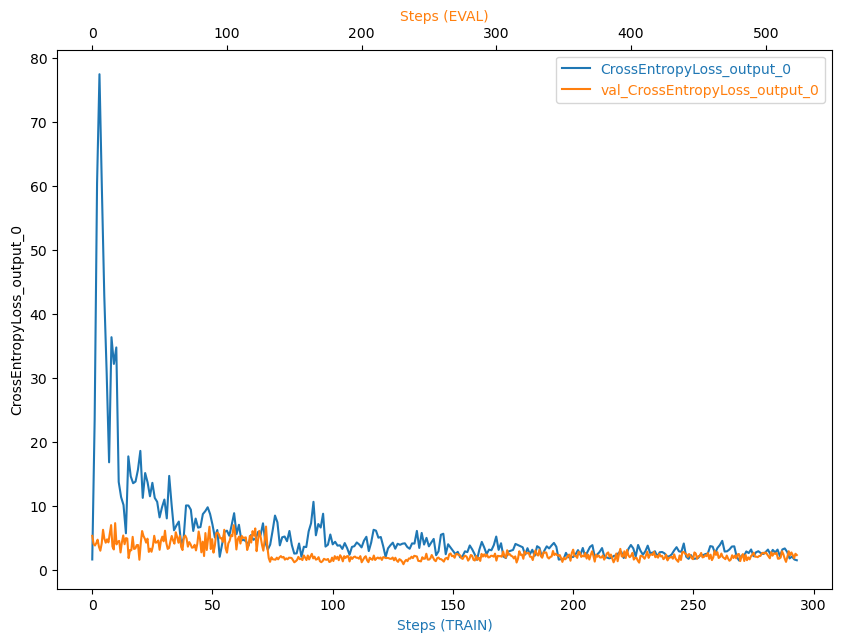

In [28]:
fig = plt.figure(figsize=(10, 7))
host = host_subplot(111)

par = host.twiny()

host.set_xlabel("Steps (TRAIN)")
par.set_xlabel("Steps (EVAL)")
host.set_ylabel(tensor_name)

(p1,) = host.plot(steps_train, vals_train, label=tensor_name)
print("completed TRAIN plot")
(p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
print("completed EVAL plot")
leg = plt.legend()

host.xaxis.get_label().set_color(p1.get_color())
leg.texts[0].set_color(p1.get_color())

par.xaxis.get_label().set_color(p2.get_color())
leg.texts[1].set_color(p2.get_color())

plt.ylabel(tensor_name)

plt.show()

In [29]:
import bokeh

In [30]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-920813457542/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-920813457542/pytorch-training-2025-01-24-09-16-21-329/profiler-output


Profiler data from system is available


In [31]:
rule_output_path = estimator_deb.output_path + estimator_deb.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-920813457542/pytorch-training-2025-01-24-09-16-21-329/rule-output


In [32]:
! aws s3 ls {rule_output_path} --recursive

2025-01-24 09:48:35     375413 pytorch-training-2025-01-24-09-16-21-329/rule-output/ProfilerReport/profiler-output/profiler-report.html
2025-01-24 09:48:35     223333 pytorch-training-2025-01-24-09-16-21-329/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2025-01-24 09:48:30        192 pytorch-training-2025-01-24-09-16-21-329/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2025-01-24 09:48:31        200 pytorch-training-2025-01-24-09-16-21-329/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2025-01-24 09:48:31       1947 pytorch-training-2025-01-24-09-16-21-329/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2025-01-24 09:48:31        127 pytorch-training-2025-01-24-09-16-21-329/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2025-01-24 09:48:31        199 pytorch-training-2025-01-24-09-16-21-329/rule-output/ProfilerReport/profiler-output/profiler-re

In [33]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-920813457542/pytorch-training-2025-01-24-09-16-21-329/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-920813457542/pytorch-training-2025-01-24-09-16-21-329/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json to ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json
download: s3://sagemaker-us-east-1-920813457542/pytorch-training-2025-01-24-09-16-21-329/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-920813457542/pytorch-training-2025-01-24-09-16-21-329/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-920813457542/pytorch-training-2025-01-24-09-16-21-329/rule-

In [34]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator_deb.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [35]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

### Model Deploying and Querying

In [36]:
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.predictor import Predictor

In [37]:
sagemaker_session = sagemaker.Session()
bucket = 'mle-project-bucket'
role = sagemaker.get_execution_role()

When trying to deploy the original model based on estimator_debug setup I got the error from the endpoint invokation 
"Response received from the primary container has headers with length greater than 4096 bytes. Reduce the length of your container's response headers and update your endpoint."

The solution I found on the [Udacity Knowledge](https://knowledge.udacity.com/questions/999383) was to change the framework version. This is why I create separate estimator fot the endpoint setup with different framework.

In [75]:
# Creating estimator based on different framework version to avoid the endpoint invokation error
estimator = PyTorch(
    entry_point="train.py",
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version="1.4.0",
    py_version="py3",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)
inputs = "s3://mle-project-bucket/dataset/bin-images/"
estimator.fit({"training": inputs}, wait=True)


[01/24/25 11:02:02] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=231086;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=204636;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=844158;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=73190;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

[01/24/25 11:02:03] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=126895;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=325493;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating training-job with name:                                       ]8;id=92790;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=948684;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\
                             pytorch-training-2025-01-24-11-02-02-816                                              

2025-01-24 11:02:03 Starting - Starting the training job...
2025-01-24 11:02:36 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
ProfilerReport: InProgress
...
2025-01-24 11:02:56 Downloading - Downloading input data...
2025-01-24 11:03:36 Downloading - Downloading the training image......
2025-01-24 11:04:36 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2025-01-24 11:04:20,258 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2025-01-24 11:04:20,262 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2025-01-24 11:04:20,274 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2025-01-24 11:04:20,276 sagemaker_pytorch_container.training INFO     Invoking user training script.
2025-01-24 11:04:20,448 sagemaker-containers INFO   

In [77]:
from sagemaker.pytorch import PyTorchModel
model_data = estimator.output_path + estimator.latest_training_job.job_name + "/output/model.tar.gz"
print(f"Model: {model_data}")

Model: s3://sagemaker-us-east-1-920813457542/pytorch-training-2025-01-24-11-02-02-816/output/model.tar.gz


In [78]:
# Already trained estimator_deb
model_data = "s3://sagemaker-us-east-1-920813457542/pytorch-training-2025-01-24-11-02-02-816/output/model.tar.gz"

In [94]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [116]:
pytorch_model = PyTorchModel(model_data=model_data, role=role, entry_point='infernce.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

[01/24/25 13:36:13] INFO     Repacking model artifact                                                  ]8;id=420821;file:///opt/conda/lib/python3.11/site-packages/sagemaker/model.py\model.py]8;;\:]8;id=242400;file:///opt/conda/lib/python3.11/site-packages/sagemaker/model.py#819\819]8;;\
                             (s3://sagemaker-us-east-1-920813457542/pytorch-training-2025-01-24-11-02-             
                             02-816/output/model.tar.gz), script artifact (None), and dependencies                 
                             ([]) into single tar.gz file located at                                               
                             s3://sagemaker-us-east-1-920813457542/pytorch-inference-2025-01-24-13-36-             
                             12-780/model.tar.gz. This may take some time depending on model size...               

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=697594;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=367361;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=994916;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=668700;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=408437;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=220538;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=649038;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=34385;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=526138;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=255637;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=286249;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=102617;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=763733;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=466331;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=103893;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=225504;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=229183;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=244973;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=487537;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=142827;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=141865;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=763127;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

[01/24/25 13:36:22] INFO     Creating model with name: pytorch-inference-2025-01-24-13-36-22-352    ]8;id=979297;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=313184;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4094\4094]8;;\

[01/24/25 13:36:23] INFO     Creating endpoint-config with name                                     ]8;id=325442;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=874172;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#5889\5889]8;;\
                             pytorch-inference-2025-01-24-13-36-23-226                                             

                    INFO     Creating endpoint with name pytorch-inference-2025-01-24-13-36-23-226  ]8;id=167985;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=938134;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4711\4711]8;;\

------!

In [117]:
import requests
request_dict={ "url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/777.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

In [108]:
request = json.loads(json.dumps({ "url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/777.jpg" }))

In [110]:
url = request['url']
img_content = requests.get(url).content
# img_content

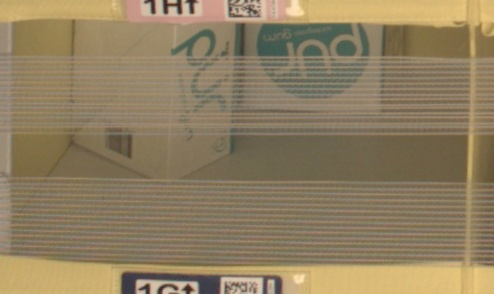

In [111]:
Image.open(io.BytesIO(img_content))

In [120]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})
response[0]

[75.46435546875,
 75.65430450439453,
 71.96678161621094,
 71.18254089355469,
 65.88207244873047]

In [121]:
np.argmax(response, 1)

array([1])

### Cheaper Training and Cost Analysis

- Normal instance training time:<br>
-- Training seconds: 1881<br>
-- Billable seconds: 1881<br>

- Spot instance training time:<br>
-- Training seconds: 1921<br>
-- Billable seconds: 714<br>
-- Managed Spot Training savings: 62.8%<br>

- Multi-instance training time:<br>
-- Training seconds: 5994<br>
-- Billable seconds: 5994<br>

After running the training jobs based on 3 above setups it looks like to most cost effective strategy in this case is using the spot instance. Spot Instances are a cost-effective choice if you can be flexible about when your applications run and if your applications can be interrupted. For example, Spot Instances are well-suited for data analysis, batch jobs, background processing, and optional tasks.

In [76]:
hyperparameters

{'batch-size': 64,
 'lr': '0.07727283462213592',
 'epochs': 3,
 'sagemaker_submit_directory': 's3://sagemaker-us-east-1-920813457542/pytorch-training-2025-01-24-11-02-02-816/source/sourcedir.tar.gz',
 'sagemaker_program': 'train.py',
 'sagemaker_container_log_level': 20,
 'sagemaker_job_name': 'pytorch-training-2025-01-24-11-02-02-816',
 'sagemaker_region': 'us-east-1'}

In [89]:
estimator_spot = PyTorch(
    entry_point='train.py',

    use_spot_instances = True, 
    max_run=7200,
    max_wait=7200,
    
    role=role,
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    
    rules=rules,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
)
inputs = "s3://mle-project-bucket/dataset/bin-images/"
estimator_spot.fit({"training": inputs}, wait=True)

[01/23/25 11:31:55] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=141579;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=770263;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=236635;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=492876;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=391254;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=987886;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating training-job with name:                                       ]8;id=15758;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=288103;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\
                             pytorch-training-2025-01-23-11-31-55-527                                              

2025-01-23 11:31:57 Starting - Starting the training job...
2025-01-23 11:32:21 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
ProfilerReport: InProgress
...
2025-01-23 11:33:01 Downloading - Downloading the training image......
2025-01-23 11:34:01 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2025-01-23 11:33:50,331 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2025-01-23 11:33:50,334 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-01-23 11:33:50,342 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2025-01-23 11:33:50,344 sagemaker_pytorch_container.training INFO     Invoking user training script.
2025-01-23 11:33:50,522 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)

### Multi-Instance Training

In [90]:
estimator_multi = PyTorch(
    entry_point='train.py',
    role=role,
    instance_count=3,
    instance_type="ml.c5.2xlarge",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    
    rules=rules,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
)
inputs = "s3://mle-project-bucket/dataset/bin-images/"
estimator_multi.fit({"training": inputs}, wait=True)

[01/23/25 12:05:13] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=924474;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=104529;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=816982;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=135510;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

[01/23/25 12:05:14] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=54348;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=885805;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

[01/23/25 12:05:15] INFO     Creating training-job with name:                                       ]8;id=845230;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=46187;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\
                             pytorch-training-2025-01-23-12-05-13-828                                              

2025-01-23 12:05:15 Starting - Starting the training job...
2025-01-23 12:05:50 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
ProfilerReport: InProgress
......
2025-01-23 12:06:50 Downloading - Downloading input data...
2025-01-23 12:07:10 Downloading - Downloading the training image...
2025-01-23 12:07:50 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2025-01-23 12:07:32,440 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2025-01-23 12:07:32,443 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-01-23 12:07:32,450 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2025-01-23 12:07:32,453 sagemaker_pytorch_container.training INFO     Invoking user training script.
2025-01-23 12:07:32,633 sagemaker-training-too